In [7]:
import requests

import osm2geojson

import geopandas as gpd

In [11]:
query = """
[out:json][timeout:25];
area[name="Brandenburg"][admin_level=4]->.searchArea;
(node["mapillary"]["traffic_sign"~"DE:240"](area.searchArea););

out body;
>;
out skel qt;
"""

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})

res_geojson = osm2geojson.json2geojson(r.json())

In [15]:
#res_geojson

<Axes: >

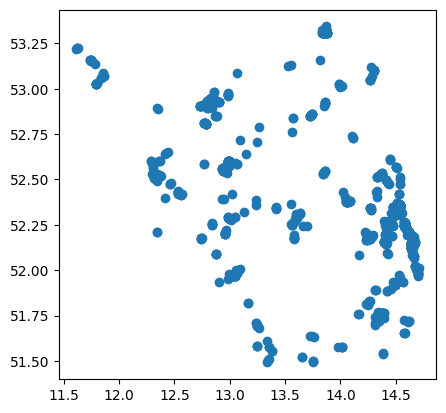

In [16]:
mpl_ts_bb = gpd.GeoDataFrame.from_features(res_geojson, crs="4326")
mpl_ts_bb.plot()

In [18]:
#mpl_ts_bb.explore()

In [19]:
mpl_ts_bb

,geometry,type,id,tags
0,POINT (13.56202 52.25073),node,60580303,"{'mapillary': '1445163752638566', 'traffic_sig..."
1,POINT (13.55933 52.25129),node,60580313,"{'mapillary': '367211269730325', 'traffic_sign..."
2,POINT (13.04287 51.96646),node,269277627,"{'mapillary': '480377027974605', 'traffic_sign..."
3,POINT (14.01995 52.42873),node,286646611,"{'mapillary': '1703358720515092', 'traffic_sig..."
4,POINT (14.41041 52.14988),node,288456613,"{'mapillary': '356511500885704', 'traffic_sign..."
...,...,...,...,...
874,POINT (14.2574 51.82891),node,13367828686,"{'mapillary': '6687336468048345', 'traffic_sig..."
875,POINT (14.26548 51.82881),node,13367846711,"{'mapillary': '509968181641807', 'traffic_sign..."
876,POINT (14.42008 52.09227),node,13367864987,"{'mapillary': '1294956395378682', 'traffic_sig..."
877,POINT (14.42898 52.09002),node,13367865000,"{'mapillary': '1362213754893266', 'traffic_sig..."


In [20]:
# Tags als separate Spalten extrahieren
import pandas as pd

# Normalisiere die tags Dictionary in separate Spalten
tags_df = pd.json_normalize(mpl_ts_bb['tags'])

# Kombiniere mit dem ursprünglichen DataFrame (ohne die tags Spalte)
mpl_ts_bb_expanded = pd.concat([
    mpl_ts_bb.drop(columns=['tags']), 
    tags_df
], axis=1)

mpl_ts_bb_expanded

,geometry,type,id,mapillary,traffic_sign,traffic_sign:direction,traffic_sign:forward,traffic_sign:backward,note,bicycle,foot,segregated,direction,side,oneway,description
0,POINT (13.56202 52.25073),node,60580303,1445163752638566,"DE:240,1000-31",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (13.55933 52.25129),node,60580313,367211269730325,DE:240,backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (13.04287 51.96646),node,269277627,480377027974605,"DE:240,1000-31",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (14.01995 52.42873),node,286646611,1703358720515092,"DE:240,1000-31",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (14.41041 52.14988),node,288456613,356511500885704,"DE:240,1000-31",forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,POINT (14.2574 51.82891),node,13367828686,6687336468048345,"DE:240,1000-31",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875,POINT (14.26548 51.82881),node,13367846711,509968181641807,"DE:240,1000-31",forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
876,POINT (14.42008 52.09227),node,13367864987,1294956395378682,"DE:240,1000-31",forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,POINT (14.42898 52.09002),node,13367865000,1362213754893266,"DE:240,1000-31",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
import os
import json
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed


# Load your access token
with open("../config.json") as f:
    MAPILLARY_TOKEN = json.load(f)["ACCESS_TOKEN"]


def get_capture_date(img_id):
    """
    Hole captured_at für eine einzelne Mapillary-Image-ID.
    Gibt captured_at timestamp zurück oder None bei Fehler.
    """
    base_url = "https://graph.mapillary.com"
    
    try:
        url = f"{base_url}/{img_id}"
        params = {
            "access_token": MAPILLARY_TOKEN,
            "fields": "captured_at",
        }
        resp = requests.get(url, params=params, timeout=10)
        resp.raise_for_status()
        data = resp.json()
        
        return data.get("captured_at")
    except Exception as e:
        return None


def parallel_get_capture_dates(image_ids, max_workers=10):
    """
    Parallelisierte Version zum Abrufen von captured_at Daten.
    Behält die Reihenfolge der Input-IDs bei.
    """
    results = [None] * len(image_ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_capture_date, img_id): idx 
                   for idx, img_id in enumerate(image_ids)}
        
        for future in tqdm(as_completed(futures), total=len(futures), 
                          desc="Fetching capture dates"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None
    
    return results


# Image IDs aus der 'mapillary' Spalte extrahieren
image_ids = mpl_ts_bb_expanded['mapillary'].tolist()

print(f"Hole Capture-Daten für {len(image_ids)} Mapillary-Bilder (parallel)...")

# Capture Dates abrufen (parallelisiert)
capture_dates_list = parallel_get_capture_dates(image_ids, max_workers=10)

# In DataFrame einfügen
mpl_ts_bb_expanded['captured_at'] = capture_dates_list

# Statistik
successful = sum(1 for v in capture_dates_list if v is not None)
print(f"✔ {successful}/{len(image_ids)} Capture-Daten erfolgreich abgerufen")

mpl_ts_bb_expanded[['mapillary', 'captured_at']].head(10)

Hole Capture-Daten für 879 Mapillary-Bilder (parallel)...


Fetching capture dates:   0%|          | 0/879 [00:00<?, ?it/s]

Fetching capture dates: 100%|██████████| 879/879 [00:35<00:00, 24.97it/s]

✔ 879/879 Capture-Daten erfolgreich abgerufen


,mapillary,captured_at
0,1445163752638566,1722158920000
1,367211269730325,1722158896000
2,480377027974605,1720515535000
3,1703358720515092,1724064315000
4,356511500885704,1721305351000
5,617295544118247,1736515206669
6,1011192583866425,1719133846000
7,1558453858211159,1725112214000
8,784382123777154,1721295706000
9,1215859803160160,1721295911000


In [25]:
mpl_ts_bb_expanded['captured_at'] = pd.to_datetime(mpl_ts_bb_expanded['captured_at'], unit='ms')
mpl_ts_bb_expanded

,geometry,type,id,mapillary,traffic_sign,traffic_sign:direction,traffic_sign:forward,traffic_sign:backward,note,bicycle,foot,segregated,direction,side,oneway,description,captured_at
0,POINT (13.56202 52.25073),node,60580303,1445163752638566,"DE:240,1000-31",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-07-28 09:28:40.000
1,POINT (13.55933 52.25129),node,60580313,367211269730325,DE:240,backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-07-28 09:28:16.000
2,POINT (13.04287 51.96646),node,269277627,480377027974605,"DE:240,1000-31",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-07-09 08:58:55.000
3,POINT (14.01995 52.42873),node,286646611,1703358720515092,"DE:240,1000-31",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-08-19 10:45:15.000
4,POINT (14.41041 52.14988),node,288456613,356511500885704,"DE:240,1000-31",forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-07-18 12:22:31.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,POINT (14.2574 51.82891),node,13367828686,6687336468048345,"DE:240,1000-31",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-05 13:40:01.732
875,POINT (14.26548 51.82881),node,13367846711,509968181641807,"DE:240,1000-31",forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-17 11:47:18.878
876,POINT (14.42008 52.09227),node,13367864987,1294956395378682,"DE:240,1000-31",forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-12 10:20:27.000
877,POINT (14.42898 52.09002),node,13367865000,1362213754893266,"DE:240,1000-31",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-12 10:25:07.000


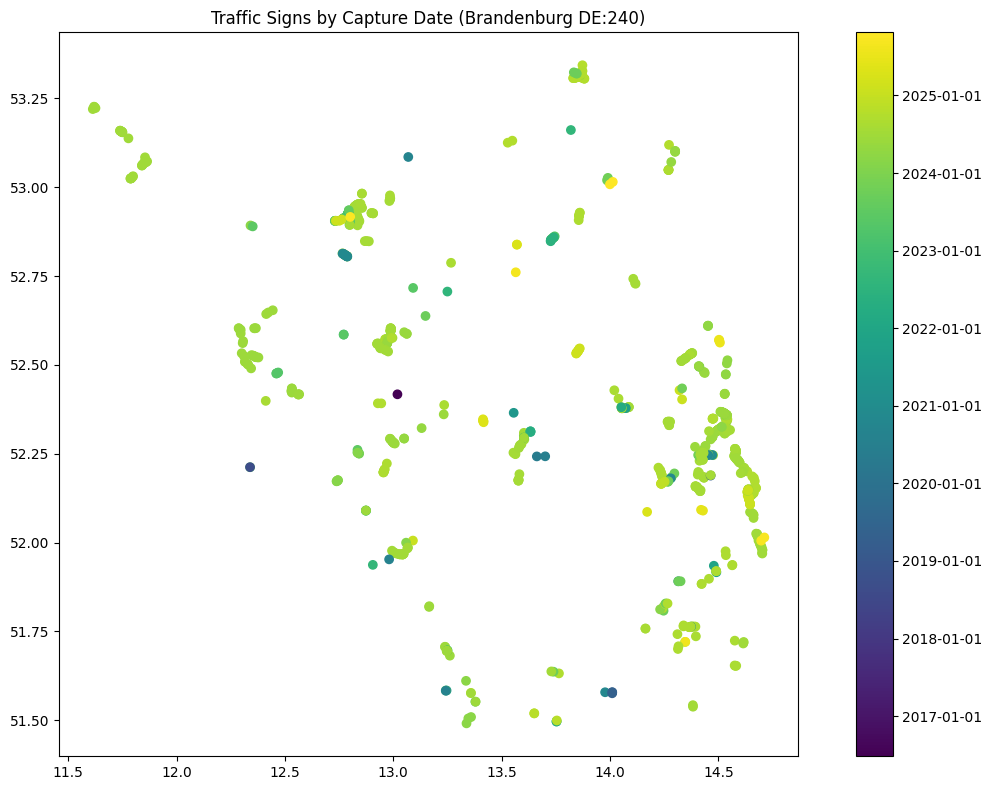

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Konvertiere datetime zu Matplotlib-Datum (Tage seit Epoche)
mpl_ts_bb_expanded['captured_at_mpl'] = mdates.date2num(mpl_ts_bb_expanded['captured_at'])

# Plot mit der Matplotlib-Datum Spalte
ax = mpl_ts_bb_expanded.plot(
    column='captured_at_mpl', 
    legend=True, 
    cmap='viridis', 
    figsize=(12, 8)
)

# Colorbar formatieren mit Datumsanzeige
cbar = ax.get_figure().get_axes()[1]  # Colorbar axis
cbar.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
cbar.yaxis.set_major_locator(mdates.AutoDateLocator())

ax.set_title('Traffic Signs by Capture Date (Brandenburg DE:240)')
plt.tight_layout()
plt.show()

In [30]:
mpl_ts_bb_expanded.sort_values('captured_at')

,geometry,type,id,mapillary,traffic_sign,traffic_sign:direction,traffic_sign:forward,traffic_sign:backward,note,bicycle,foot,segregated,direction,side,oneway,description,captured_at,captured_at_numeric,captured_at_mpl
291,POINT (13.01931 52.41737),node,12031786710,899693687546451,DE:240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-25 11:39:11.000,1.466855e+09,16977.485544
751,POINT (12.3392 52.21235),node,12598774078,524752752018212,"DE:240,1000-31",forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-30 09:24:07.815,1.535621e+09,17773.391757
789,POINT (14.46451 52.18862),node,12728269621,1880705372089962,"DE:240,1000-31",forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-05 10:48:25.674,1.554461e+09,17991.450297
840,POINT (14.01003 51.57607),node,13018660166,157845052950174,DE:240,forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-06 06:02:28.564,1.557123e+09,18022.251719
107,POINT (14.01023 51.5784),node,2393754234,1124034434675598,DE:240,forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-06 06:03:01.554,1.557123e+09,18022.252101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,POINT (14.71217 52.01464),node,13272377705,801092789641817,"DE:240,1020-30",forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-16 08:15:18.000,1.758011e+09,20347.343958
859,POINT (14.6975 52.00548),node,13272377706,1768384683821405,"DE:240,1020-30",backward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-16 08:20:01.000,1.758011e+09,20347.347234
852,POINT (12.80148 52.91655),node,13257390157,815201461202090,DE:240,forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-05 11:58:53.438,1.759666e+09,20366.499230
868,POINT (13.99984 53.00825),node,13363113701,2072971146776846,"DE:240,1000-30",70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-25 06:22:45.000,1.761373e+09,20386.265799
